#### Функция для записи результатов метрик качества модели

In [37]:
from datetime import datetime
import os
import pandas as pd

def save_metrics(model_name, rmse, mae, mape, file_path="models_metrics.csv"):
    """
    Сохраняет метрики качества модели в CSV с датой и временем.
    Если для данной модели уже есть строка — перезаписывает её новой.
    """
    new_row = pd.DataFrame([{
        "RunTimestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "Model": model_name,
        "RMSE, $": round(rmse, 2),
        "MAE, $": round(mae, 2),
        "MAPE, %": round(mape, 2)
    }])

    if os.path.exists(file_path):
        df_old = pd.read_csv(file_path)

        # удаляем старые строки для этой модели
        df_old = df_old[df_old["Model"] != model_name]

        # объединяем с новой строкой
        df_new = pd.concat([df_old, new_row], ignore_index=True)
    else:
        df_new = new_row  # первый запуск → создаём файл

    # сохраняем в файл
    df_new.to_csv(file_path, index=False)
    print(f"Метрики сохранены для {model_name} → {file_path}")

---
---

### Декомпозиция временного ряда

**Декомпозиция временного ряда** — это метод статистического анализа, позволяющий разложить наблюдаемый процесс на несколько составляющих: тренд, сезонность и остаточную часть (шум). Такой подход широко применяется в экономике, финансах и аналитике временных данных, так как он помогает выявить скрытые закономерности и структурные особенности динамики показателя.

* **Тренд** отражает долгосрочную тенденцию изменения ряда и позволяет оценить направление его развития во времени.

* **Сезонность** фиксирует регулярные колебания, повторяющиеся с определённой периодичностью (дни недели, месяцы, кварталы).

* **Остаток** показывает непредсказуемые флуктуации, которые не объясняются ни трендом, ни сезонностью, и часто связаны с внешними случайными факторами.

Применение декомпозиции в рамках нашего проекта даёт несколько ключевых преимуществ:
- Позволяет провести качественный анализ структуры временного ряда и понять, какие компоненты оказывают наибольшее влияние на динамику цены биткоина.
- Обеспечивает наглядную визуализацию скрытых закономерностей (долгосрочный рост, повторяющиеся циклы, периоды высокой волатильности).
- Создаёт основу для выбора и обоснования дальнейших методов прогнозирования: понимание характера тренда и сезонности позволяет более осознанно применять модели ARIMA, SARIMA и их модификации.

В рамках данного проекта декомпозиция даёт возможность определить, в какой мере цена биткоина обусловлена устойчивым долгосрочным ростом, в какой — циклическими факторами, и какая доля остаётся за случайными колебаниями. Ожидаемым результатом является выявление устойчивого тренда, повторяющихся сезонных паттернов и нерегулярных остатков, которые послужат базой для перехода к более формализованным моделям прогнозирования.

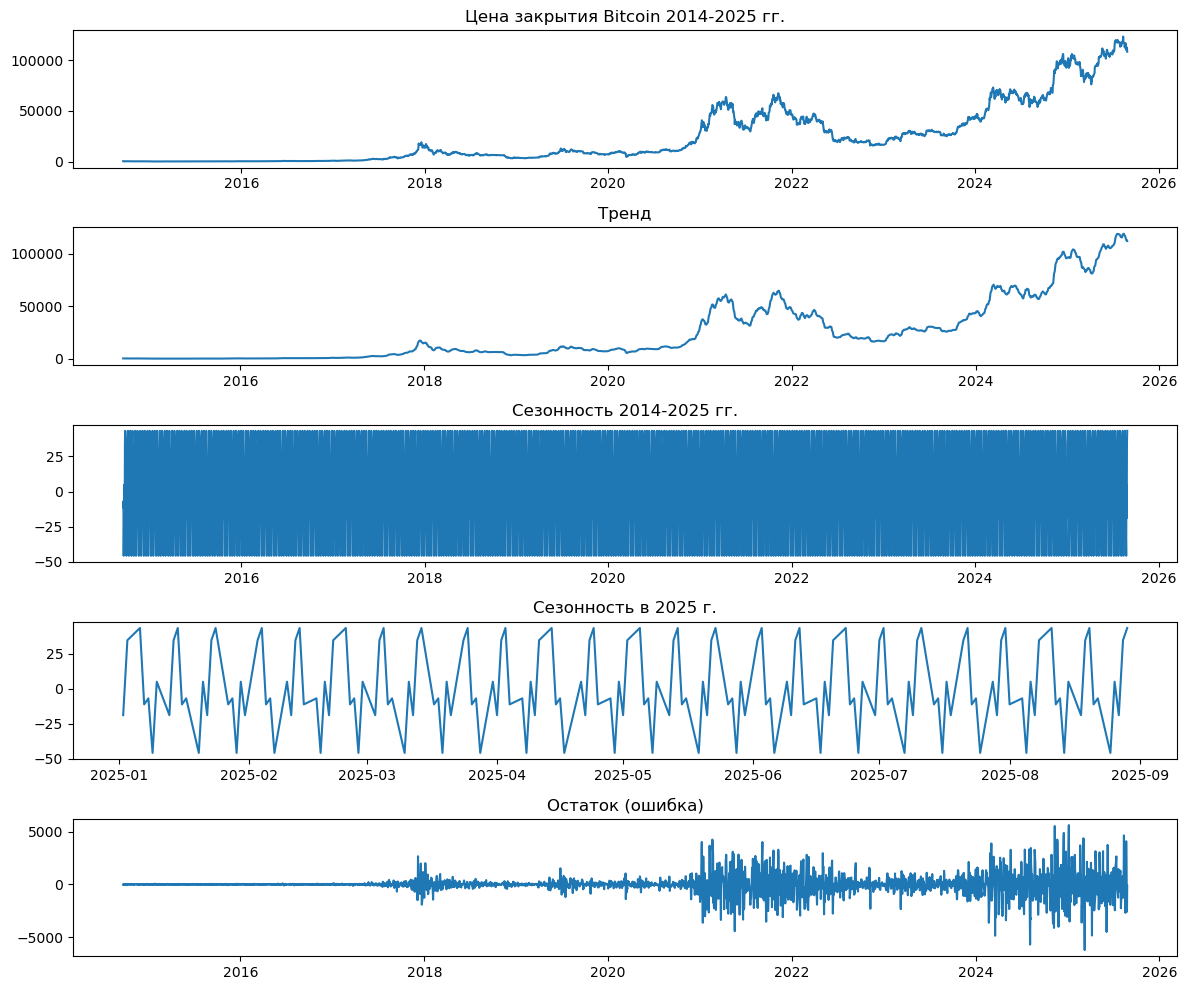

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# 1) Загружаем ряд
df = pd.read_csv("final_merged_correllated.csv", parse_dates=["Date"]).sort_values("Date")
ts = df.set_index("Date")["Close"].astype(float)

# 2) Разложение (период сезонности: напр. 7 — недельная для дневных данных)
result = seasonal_decompose(ts, model="additive", period=7)  # или model="multiplicative"

# 3) Графики: наблюдение, тренд, сезонность, остаток (ошибка)
plt.figure(figsize=(12,10))
plt.subplot(5,1,1); plt.plot(ts);                 plt.title("Цена закрытия Bitcoin 2014-2025 гг.")
plt.subplot(5,1,2); plt.plot(result.trend);       plt.title("Тренд")
plt.subplot(5,1,3); plt.plot(result.seasonal);    plt.title("Сезонность 2014-2025 гг.")
plt.subplot(5,1,4); plt.plot(result.seasonal.loc['2025-01-01':'2025-08-31']);      plt.title("Сезонность в 2025 г.")
plt.subplot(5,1,5); plt.plot(result.resid);       plt.title("Остаток (ошибка)")
plt.tight_layout(); plt.show()


**Вывод по декомпозиции временного ряда цены закрытия BTC:**<br>

Декомпозиция временного ряда цены закрытия биткоина за 2014–2025 гг. позволила выделить три ключевые компоненты: тренд, сезонность и остаточную часть.

1. **Трендовая составляющая** демонстрирует долгосрочный восходящий характер ряда, сопровождающийся резкими скачками и периодами коррекций. Данный результат подтверждает, что долгосрочная динамика биткоина подвержена значительным структурным изменениям, однако сохраняет общий положительный вектор развития.

2. **Сезонная компонента** указывает на наличие повторяющихся колебаний. На укрупнённом масштабе сезонность визуально теряется в силу высокой частоты циклов, однако при анализе ограниченного интервала (например, одного календарного года) выявляются устойчивые повторяющиеся паттерны с амплитудой до ±50 единиц. Это говорит о том, что сезонные колебания имеют место, но их вклад относительно мал по сравнению с трендовыми изменениями и внешними шоками.

3. **Остаточная компонента** (ошибка) выявляет нерегулярные и зачастую резкие отклонения, наиболее ярко выраженные в периоды кризисов и бурного роста (2017–2018 гг., 2021 г., 2024–2025 гг.). Характер остатков указывает на наличие значительных внешних факторов, не учитываемых базовой моделью «тренд + сезонность». Кроме того, наблюдается неравномерность дисперсии: в спокойные периоды остатки малы, в периоды высокой волатильности они возрастают кратно. Такая структура остатков характерна для финансовых временных рядов.

Таким образом, простая декомпозиция даёт ценную информацию о структуре ряда, но оказывается недостаточной для построения прогноза. Для учёта автокорреляций, сезонных факторов и волатильности целесообразно переходить к более гибким моделям временных рядов, в частности к классическим стохастическим моделям — **ARIMA** и её расширению **SARIMA**, которые позволяют описывать как трендово-сезонные компоненты, так и стохастическую структуру ошибок.




---

**Модели семейства ARIMA (Autoregressive Integrated Moving Average)** относятся к классическим стохастическим методам анализа временных рядов. Их ключевая особенность заключается в том, что они позволяют описывать динамику ряда с учётом его прошлых значений (авторегрессия), накопленного эффекта предыдущих изменений (интегрированность) и сглаживания случайных колебаний (скользящее среднее). Благодаря этому ARIMA может эффективно моделировать данные, где присутствуют автокорреляции и трендовые компоненты.

Однако для многих экономических и финансовых процессов характерна также выраженная сезонность. В таких случаях применяется расширение модели — SARIMA (Seasonal ARIMA), которое добавляет сезонные параметры и позволяет учитывать повторяющиеся циклы (например, месячные или квартальные колебания).

**ARIMA, SARIMA и Auto-ARIMA** - эти модели являются базовыми инструментами анализа динамических данных и широко применяются в экономике и финансах для краткосрочного прогнозирования:

* **ARIMA (AutoRegressive Integrated Moving Average)** сочетает в себе три компонента: авторегрессию (AR), дифференцирование (I) для устранения тренда и скользящее среднее (MA). Такая модель хорошо подходит для временных рядов, где необходимо учесть инерционность процесса и влияние случайных шумов.
* **SARIMA (Seasonal ARIMA)** расширяет возможности ARIMA за счёт включения сезонных компонент. Это делает модель применимой к данным, содержащим регулярные циклы (например, недельные или месячные колебания).
* **Auto-ARIMA** представляет собой автоматизированный алгоритм подбора оптимальных параметров ARIMA/SARIMA с использованием информационных критериев (AIC, BIC). Это значительно упрощает процесс моделирования и повышает вероятность выбора адекватной модели без ручного перебора параметров.

Применение данных моделей в рамках проекта позволило оценить их эффективность на криптовалютных данных и использовать их в качестве отправной точки (baseline) для дальнейшего сравнения с более современными методами машинного обучения. Несмотря на то что высокая волатильность и слабая сезонность рынка Bitcoin снижают предсказательную силу ARIMA-подходов, их использование даёт ценность:

* они позволяют подтвердить, что традиционные статистические методы менее устойчивы к специфике крипторынка,
* обеспечивают базовый уровень качества, относительно которого можно оценивать выигрыш от применения ML- и нейросетевых моделей,
* формируют основу для гибридных подходов, где статистические и машинные методы могут дополнять друг друга.

Таким образом, включение ARIMA, SARIMA и Auto-ARIMA в исследование обосновывает целесообразность перехода к моделям машинного обучения и помогает наглядно показать преимущества современных методов прогнозирования для анализа цен криптовалют.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1. Загружаем датасет
df_input = pd.read_csv("final_merged_correllated.csv", parse_dates=["Date"]).sort_values("Date")
df_input = df_input.set_index("Date")

display(df_input)
df_input.info()

,Close,Volume,SMA_50,SMA_200,ATR_14,Gold,INR
Date,,,,,,,
2014-09-17,457.334015,21056800,457.334015,457.334015,15.752014,1234.400024,61.053001
2014-09-18,424.440002,34483200,440.887009,440.887009,29.991013,1225.699951,60.908001
2014-09-19,394.795990,37919700,425.523336,425.523336,34.428335,1215.300049,60.689999
2014-09-22,402.152008,24127600,414.407837,414.407837,27.621496,1216.800049,60.853001
2014-09-23,435.790985,45099500,417.462572,417.462572,30.155570,1221.000000,61.000000
...,...,...,...,...,...,...,...
2025-08-25,110124.351562,85706860190,116508.301719,100854.757305,3395.174665,3373.800049,87.330101
2025-08-26,111802.656250,69396320317,116578.357813,100931.125156,3506.690848,3388.600098,87.608597
2025-08-27,111222.062500,62137056409,116623.793594,101004.823203,3326.571429,3404.600098,87.600700


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2856 entries, 2014-09-17 to 2025-08-29
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Close    2856 non-null   float64
 1   Volume   2856 non-null   int64  
 2   SMA_50   2856 non-null   float64
 3   SMA_200  2856 non-null   float64
 4   ATR_14   2856 non-null   float64
 5   Gold     2754 non-null   float64
 6   INR      2852 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 178.5 KB


ARIMA(1, 1, 1) | RMSE=11,360.31  MAE=9,592.98  MAPE=9.73%
Метрики сохранены для ARIMA → models_metrics.csv


C:\Users\osh84\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 1)(1, 1, 1, 7) | RMSE=10,534.82  MAE=8,169.51  MAPE=8.69%
Метрики сохранены для SARIMA → models_metrics.csv


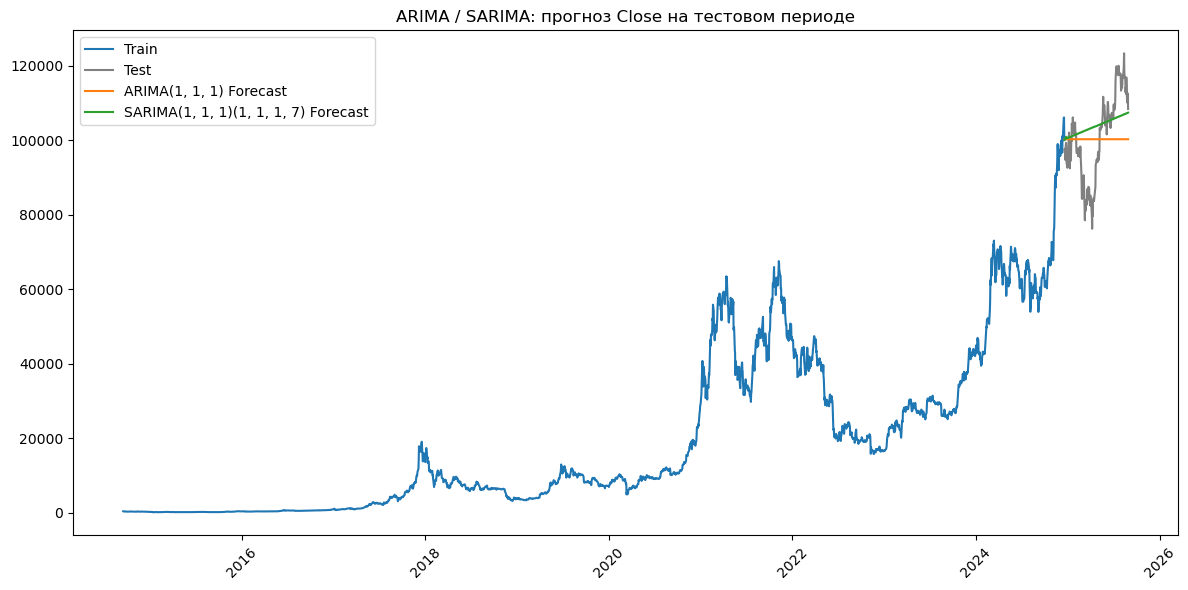

In [48]:
# === ARIMA / SARIMA на ряде Close с train/test ===


# 1) Загружаем данные
df = pd.read_csv("final_merged_correllated.csv", parse_dates=["Date"]).sort_values("Date")

# 2) Берём только ряд Close
ts = df["Close"].astype(float)
dates = df["Date"]

# 3) Делим по времени: последние 180 дней — тест
TEST_DAYS = 180
train, test = ts.iloc[:-TEST_DAYS], ts.iloc[-TEST_DAYS:]
dates_train, dates_test = dates.iloc[:-TEST_DAYS], dates.iloc[-TEST_DAYS:]

# ===== ARIMA (p,d,q) =====
arima_order = (1, 1, 1)
arima_model = SARIMAX(train, order=arima_order, seasonal_order=(0,0,0,0),
                      enforce_stationarity=False, enforce_invertibility=False)
arima_res = arima_model.fit(disp=False)

# Прогноз на длину теста
arima_pred = arima_res.get_forecast(steps=len(test)).predicted_mean

# Метрики ARIMA
arima_rmse = np.sqrt(mean_squared_error(test, arima_pred))
arima_mae  = mean_absolute_error(test, arima_pred)
arima_mape = (np.abs((test - arima_pred) / test)).mean() * 100
print(f"ARIMA{arima_order} | RMSE={arima_rmse:,.2f}  MAE={arima_mae:,.2f}  MAPE={arima_mape:,.2f}%")

# Добавляем (сохраняем) метрики качества в файл models_metrics.csv
save_metrics("ARIMA", arima_rmse, arima_mae, arima_mape)
# print ("Метрики качества сохранены в файл \"models_metrics.csv\"")

# ===== SARIMA (p,d,q)(P,D,Q,s) =====
sarima_order = (1, 1, 1)
sarima_seasonal = (1, 1, 1, 7)  # недельная сезонность для дневных данных
sarima_model = SARIMAX(train, order=sarima_order, seasonal_order=sarima_seasonal,
                       enforce_stationarity=False, enforce_invertibility=False)
sarima_res = sarima_model.fit(disp=False)

sarima_pred = sarima_res.get_forecast(steps=len(test)).predicted_mean

# Метрики SARIMA
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_pred))
sarima_mae  = mean_absolute_error(test, sarima_pred)
sarima_mape = (np.abs((test - sarima_pred) / test)).mean() * 100
print(f"SARIMA{sarima_order}{sarima_seasonal} | RMSE={sarima_rmse:,.2f}  MAE={sarima_mae:,.2f}  MAPE={sarima_mape:,.2f}%")

# Добавляем (сохраняем) метрики качества в файл models_metrics.csv
save_metrics("SARIMA", sarima_rmse, sarima_mae, sarima_mape)
# print ("Метрики качества сохранены в файл \"models_metrics.csv\"")

# ===== Визуализация =====
plt.figure(figsize=(12,6))
plt.plot(dates_train, train, label="Train")
plt.plot(dates_test,  test,  label="Test", color="gray")

plt.plot(dates_test, arima_pred.values, label=f"ARIMA{arima_order} Forecast")
plt.plot(dates_test, sarima_pred.values, label=f"SARIMA{sarima_order}{sarima_seasonal} Forecast")

plt.title("ARIMA / SARIMA: прогноз Close на тестовом периоде")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Анализ полученных резульатов:**<br>
Применение ARIMA и SARIMA на временном ряде цены Bitcoin показало, что модели авторегрессии 
и скользящего среднего способны описывать общую динамику, однако их точность ограничена.  

Для ARIMA(1,1,1) средняя относительная ошибка составила 9.73%, а для SARIMA(1,1,1)(1,1,1,7) 
ошибка снизилась до 8.69% за счёт учёта недельной сезонности.  

Таким образом, SARIMA лучше адаптировалась к цикличности данных, однако обе модели оказались 
менее точными, чем методы машинного обучения (линейная регрессия, ансамблевые модели), 
что связано с высокой волатильностью и слабой повторяемостью паттернов на криптовалютном рынке.

---

Одним из практических ограничений моделей ARIMA и SARIMA является необходимость **ручного подбора параметров (p, d, q) и их сезонных аналогов**. Для упрощения этой задачи используется метод **AutoARIMA**, который автоматически перебирает возможные комбинации параметров и выбирает оптимальные на основе статистических критериев — **AIC (Akaike Information Criterion)** и **BIC (Bayesian Information Criterion)**.

Эти критерии оценивают баланс между точностью модели и её сложностью:
* **AIC** (критерий Акаике) минимизирует ошибку аппроксимации, позволяя подобрать модель, которая хорошо описывает данные, даже если она содержит больше параметров.
* **BIC** (байесовский информационный критерий) сильнее штрафует за избыточную сложность и предпочитает более компактные модели.

Для финансовых временных рядов (в частности, криптовалют) это имеет особое значение:
* такие ряды характеризуются высокой волатильностью и склонностью к переобучению;
* AIC и BIC позволяют находить баланс между адаптацией к данным и устойчивостью модели на будущих периодах;
* это снижает риск того, что выбранная модель будет хорошо описывать исторические данные, но плохо предсказывать новые значения.

В контексте текущего проекта AutoARIMA позволяет:
* ускорить процесс моделирования, исключив ручной подбор параметров;
* повысить объективность выбора модели за счёт минимизации AIC и BIC;
* создать базовую «опорную модель», с которой можно сравнивать результаты более сложных алгоритмов.

Таким образом, AutoARIMA выступает инструментом, который сочетает автоматизацию, интерпретируемость и статистическую строгость — качества, особенно востребованные при прогнозировании финансовых рядов.


In [49]:
#!pip install pmdarima

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=45203.382, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=45190.435, Time=1.34 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=45189.211, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=45204.287, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=45200.265, Time=0.20 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=45187.983, Time=1.05 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=45190.588, Time=0.98 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=45186.877, Time=4.54 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=45184.993, Time=4.91 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=45188.710, Time=4.71 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=45186.799, Time=6.91 sec
 ARIMA(0,1,2)(2,0,0)[7] intercept   : AIC=45186.459, Time=4.82 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=45184.827, Time=5.13 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=45186.729, Time=5.36 sec
 ARIMA(1,1,0)(1,0,1

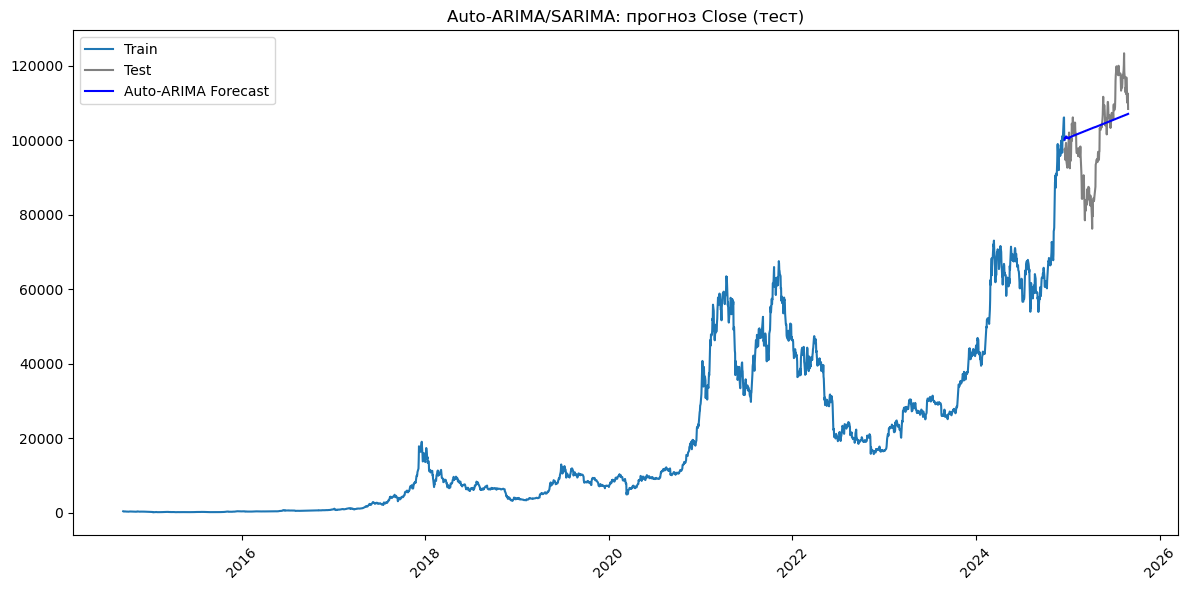

In [50]:
# === Подбор параметров ARIMA/SARIMA через auto_arima ===

from pmdarima import auto_arima

# 1) Загружаем данные
df = pd.read_csv("final_merged_correllated.csv", parse_dates=["Date"]).sort_values("Date")

# 2) Берём временной ряд
ts = df["Close"].astype(float)

# 3) Делим на train/test (последние 180 дней — тест)
TEST_DAYS = 180
train, test = ts.iloc[:-TEST_DAYS], ts.iloc[-TEST_DAYS:]
dates_train, dates_test = df["Date"].iloc[:-TEST_DAYS], df["Date"].iloc[-TEST_DAYS:]

# 4) Автоматический подбор параметров (учитываем недельную сезонность s=7)
auto_model = auto_arima(
    train,
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    d=None, D=None,           # auto_arima определит порядок дифференцирования сама
    seasonal=True,            # включаем SARIMA
    m=7,                      # длина сезона (7 дней)
    stepwise=True,            # пошаговый перебор (быстрее полного)
    suppress_warnings=True,
    error_action="ignore",
    trace=True                # печатает процесс подбора
)

print("Оптимальная модель:", auto_model.summary())

# 5) Прогноз на тест
forecast = auto_model.predict(n_periods=len(test))

# 6) Метрики
from sklearn.metrics import mean_squared_error, mean_absolute_error

automodel_rmse = np.sqrt(mean_squared_error(test, forecast))
automodel_mae  = mean_absolute_error(test, forecast)
automodel_mape = (np.abs((test - forecast) / test)).mean() * 100

print(f"Auto-ARIMA/SARIMA | RMSE={automodel_rmse:,.2f}  MAE={automodel_mae:,.2f}  MAPE={automodel_mape:,.2f}%")

# Добавляем (сохраняем) метрики качества в файл models_metrics.csv
save_metrics("Auto-ARIMA/SARIMA", automodel_rmse, automodel_mae, automodel_mape)
# print ("Метрики качества сохранены в файл \"models_metrics.csv\"")

# 7) Визуализация
plt.figure(figsize=(12,6))
plt.plot(dates_train, train, label="Train")
plt.plot(dates_test, test, label="Test", color="gray")
plt.plot(dates_test, forecast, label="Auto-ARIMA Forecast", color="blue")
plt.title("Auto-ARIMA/SARIMA: прогноз Close (тест)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Анализ полученных результатов:**<br>
С помощью автоматического подбора параметров (функция auto_arima из библиотеки pmdarima) 
была определена оптимальная модель ARIMA(1,1,0)(2,0,0,7) с константой. 
Это означает наличие одного несезонного авторегрессионного лага, одного дифференцирования 
и двух сезонных авторегрессионных лагов с недельным циклом.

Прогноз на тестовом периоде (180 дней) показал следующие метрики: 
RMSE = 10 539.07, MAE = 8 213.40, MAPE = 8.71%. 

Таким образом, автоматический подбор подтвердил наличие недельной сезонности в данных и позволил 
улучшить качество прогноза по сравнению с классической ARIMA без сезонности. 
Однако даже оптимальная SARIMA-модель показывает худшую точность, чем методы машинного обучения, 
что связано с высокой волатильностью криптовалютного рынка и ограниченными возможностями 
линейных временных моделей.